In [1]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
pandas:  2.0.0
numpy:  1.22.2
seaborn:  0.11.2
matplotlib:  3.7.1
sklearn:  1.2.2
Tensorflow:  2.7.0


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [4]:
filePath = './data/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()

284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])



In [10]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


In [36]:
#simple autoencoder
logfilename = "simpleautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_10 (Dense)            (None, 12)                360       
                                                                 
 dense_11 (Dense)            (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [50]:
#sparse autoencoder
logfilename = "sparseautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu',
               activity_regularizer=regularizers.l1(10e-5))(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_12 (Dense)            (None, 12)                360       
                                                                 
 dense_13 (Dense)            (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [56]:
#deep autoencoder
logfilename = "deepautoencoder"

encoding_dim = 16
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_14 (Dense)            (None, 16)                480       
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dense_16 (Dense)            (None, 4)                 36        
                                                                 
 dense_17 (Dense)            (None, 8)                 40        
                                                                 
 dense_18 (Dense)            (None, 16)                144       
                                                                 
 dense_19 (Dense)            (None, 29)                493 

In [57]:
autoencoder.compile(optimizer=RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [58]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='./logs/{0}'.format(logfilename))])

Epoch 1/20
510/510 [==============================] - 4s 6ms/step - loss: 1.4301 - mae: 0.6734 - accuracy: 0.1843 - val_loss: 1.7516 - val_mae: 0.6782 - val_accuracy: 0.3924
Epoch 2/20
510/510 [==============================] - 3s 6ms/step - loss: 1.3797 - mae: 0.6528 - accuracy: 0.4273 - val_loss: 1.7353 - val_mae: 0.6731 - val_accuracy: 0.4593
Epoch 3/20
510/510 [==============================] - 3s 6ms/step - loss: 1.3680 - mae: 0.6502 - accuracy: 0.4834 - val_loss: 1.7259 - val_mae: 0.6711 - val_accuracy: 0.5039
Epoch 4/20
510/510 [==============================] - 3s 6ms/step - loss: 1.3605 - mae: 0.6489 - accuracy: 0.5247 - val_loss: 1.7203 - val_mae: 0.6706 - val_accuracy: 0.5350
Epoch 5/20
510/510 [==============================] - 3s 6ms/step - loss: 1.3576 - mae: 0.6485 - accuracy: 0.5484 - val_loss: 1.7189 - val_mae: 0.6702 - val_accuracy: 0.5458
Epoch 6/20
510/510 [==============================] - 3s 6ms/step - loss: 1.3565 - mae: 0.6482 - accuracy: 0.5578 - val_loss: 1.71

In [59]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 [==============================] - 0s 3ms/step - loss: 1.7161 - mae: 0.6696 - accuracy: 0.5723
Test loss: 1.7161146402359009
Test accuracy: 0.669629693031311


In [60]:
threshold=10.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)



In [61]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3987
           1       0.42      0.83      0.55        93

    accuracy                           0.97      4080
   macro avg       0.71      0.90      0.77      4080
weighted avg       0.98      0.97      0.97      4080



In [42]:
roc_auc_score(y_test, y_label)

0.806310023706077

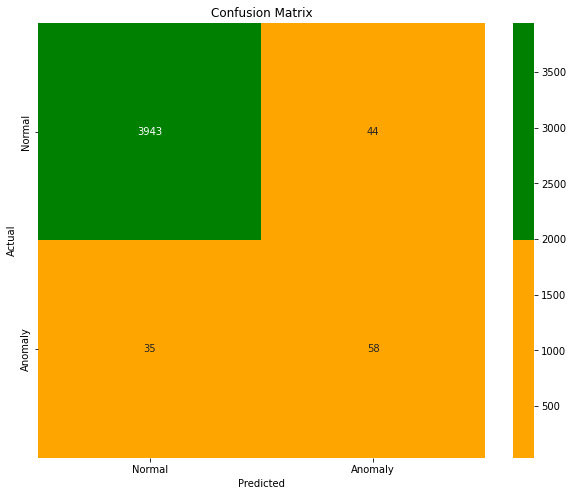

In [43]:
viz = Visualization()
viz.draw_confusion_matrix(y_test, y_label)

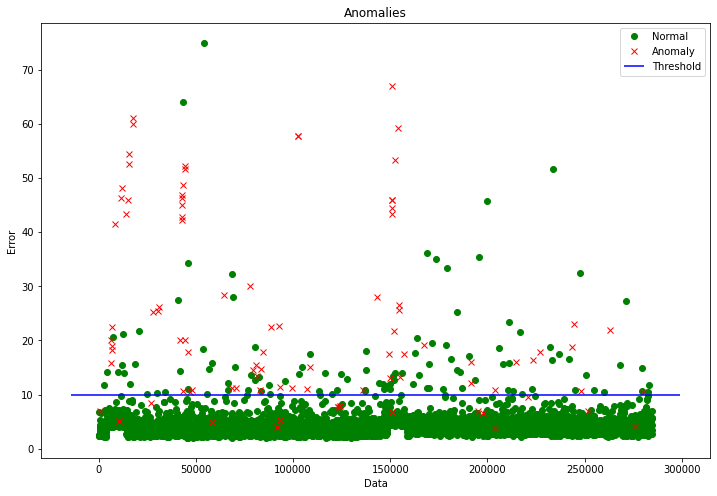

In [46]:
viz.draw_anomaly(y_test, error, threshold)